# Uncertainty Quantification Methods on multi-coil k-space data

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import h5py
from numpy.fft import fftshift, ifft2
import random
import SimpleITK as sitk
from typing import Dict, Any, List, Tuple
import scipy.ndimage

# Parameters


In [2]:
tmpdir = Path('/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp')
print(tmpdir)   

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp


# Loading data


In [3]:
# shape of the data: (averages, slices, coils, rows, columns)

def load_patient_data(patient_dict: dict, debug=False) -> dict:
    """
    Loads the k-space and reconstruction data for a given patient from the h5 file.
    
    Args:
    - patient_dict (dict): Dictionary containing the necessary paths and indices for the patient.
    
    Returns:
    - patient_dict (dict): The updated dictionary containing loaded data.
    """
    with h5py.File(patient_dict["h5_path"], 'r') as f:
        print(f"\nLoaded data for {patient_dict['h5_path']}")

        patient_dict["kspace"] = f['kspace'][:]
        patient_dict["slice_ksp"] = patient_dict["kspace"][patient_dict["avg_idx"], 
                                                          patient_dict["slice_idx"], 
                                                          patient_dict["coil_idx"], ...]
        print(f"Slice ksp shape: {patient_dict['slice_ksp'].shape}")
        
        # Optional: Convert to image space (inverse FFT)
        patient_dict["slice_img"] = np.fft.ifft2(patient_dict["slice_ksp"])
        
        if debug:
            for key in f.keys():
                print(key)
            for attr in f.attrs:
                print(attr, f.attrs[attr])

        # Debug: Print the shape and dtype of the k-space data
        print(f"\nkspace Shape: {patient_dict['kspace'].shape}")
        print(f"kspace dtpe: {patient_dict['kspace'].dtype}")
        
    return patient_dict

In [4]:
pat3 = {
    "h5_path": Path("/scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5"),
    "pat_id": "0003_umcg_pst_ksps",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}
pat4 = {
    "h5_path": "/scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5",
    "pat_id": "0004_ANON9616598",
    "kspace": None,
    "slice_idx": 15,          
    "avg_idx": 0,                 #  0: first avg, 1: second avg, 2: third avg
    "coil_idx": 0,                #  0: first coil, 1: second coil, 2: third coil etc .. 19: last coil
    "slice_ksp": None,            # The slice data from the kspace
    "slice_img": None,            # The slice data from the recon
}

pat3 = load_patient_data(pat3, debug=True)
pat4 = load_patient_data(pat4, debug=True)


Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0003_ANON5046358/h5s/meas_MID00401_FID373323_t2_tse_traobl_p2_384-out_2.h5
Slice ksp shape: (768, 651)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 384 307   0]
acquisition AXT2
cols_dcm_hdr 768
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_steps_dcm_hdr 651
norm 0.12
pat_pos_dcm_hdr HFS
patient_id ANON5046358
patient_id_seq 0003
percent_phase_fov_dcm_hdr 100.0
percent_sampling_dcm_hdr 80.0
pixel_spacing_dcm_hdr [0.234375 0.234375]
rows_dcm_hdr 768

kspace Shape: (3, 30, 20, 768, 651)
kspace dtpe: complex64

Loaded data for /scratch/p290820/datasets/003_umcg_pst_ksps/data/0004_ANON9616598/h5s/meas_MID00460_FID707792_T2_TSE_tra_obl-out_2.h5
Slice ksp shape: (640, 551)
ismrmrd_header
kspace
acq_mat_dcm_hdr [  0 320 256   0]
acquisition AXT2
cols_dcm_hdr 640
do_norm_to_ref True
do_rm_zero_pad True
max 0.0004
max_phase_crop None
n_averages_dcm_hdr 3.0
n_phase_enc_step

# Pre-processing


## Collapse averages for ease of use

In [5]:
def collapse_averages(kspace_data: np.ndarray) -> np.ndarray:
    """
    Collapse the averages in the k-space data.
    
    The input kspace_data must have shape (averages, slices, coils, rows, columns)
    with exactly 3 averages. The combination is performed as:
        combined_kspace = (avg1 + avg3) / 2 + avg2
    
    Args:
        kspace_data (np.ndarray): Complex k-space data.
        
    Returns:
        np.ndarray: Combined k-space data with shape (slices, coils, rows, columns).
    """
    assert isinstance(kspace_data, np.ndarray), "kspace_data must be a numpy array"
    assert kspace_data.ndim == 5, "Expected kspace_data to have 5 dimensions, got {}".format(kspace_data.ndim)
    assert kspace_data.shape[0] == 3, f"Expected 3 averages, got {kspace_data.shape[0]}"
    
    combined_kspace = ((kspace_data[0, ...] + kspace_data[2, ...]) / 2) + kspace_data[1, ...]
    return combined_kspace


# lets add it to pat3 and pat4 as dict key and value
pat3["combined_kspace"] = collapse_averages(pat3["kspace"])
pat4["combined_kspace"] = collapse_averages(pat4["kspace"])

# Make an RSS Reconstruction


In [6]:
def combine_coils_rss(img_data: np.ndarray) -> np.ndarray:
    """
    Combine the coil images using the root-sum-of-squares (RSS) method.

    Args:
        img_data (np.ndarray): Image data with shape (slices, coils, rows, columns).
    
    Returns:
        np.ndarray: Combined image with shape (slices, rows, columns).
    """
    assert isinstance(img_data, np.ndarray), "img_data must be a numpy array"
    assert img_data.ndim == 4, f"Expected img_data to have 4 dimensions, got {img_data.ndim}"
    
    # Compute RSS over the coil dimension (axis=1)
    combined_img = np.sqrt(np.sum(np.abs(img_data) ** 2, axis=1))
    return combined_img


def reconstruct_image_RSS(kspace_data: np.ndarray) -> np.ndarray:
    """
    Reconstruct an image from the provided k-space data.
    
    Steps:
    1. Shift the k-space data to center.
    2. Perform 2D inverse FFT.
    3. Shift the resulting image.
    4. Combine the coils using the RSS
    5. Return the final image.
    
    Args:
        kspace_data (np.ndarray): K-space data with shape (averages, slices, coils, rows, columns).
    
    Returns:
        np.ndarray: Reconstructed image with shape (slices, rows, columns).
    """
    # combined_kspace = collapse_averages(kspace_data)
    # combined_kspace shape: (slices, coils, rows, columns)
    # Perform 2D inverse FFT on the last two dimensions (for each slice and coil)

    assert isinstance(kspace_data, np.ndarray), "kspace_data must be a numpy array"
    assert kspace_data.ndim == 4, f"Expected kspace_data to have 4 dimensions, got {kspace_data.ndim}"
    
    # 1) Shift k-space to center
    shifted_kspace = np.fft.ifftshift(kspace_data, axes=(-2, -1))

    # 2) Perform 2D inverse FFT
    img_coils = np.fft.ifft2(shifted_kspace, axes=(-2, -1))

    # 3) Shift the resulting image
    img_coils = np.fft.fftshift(img_coils, axes=(-2, -1))
    
    # Combine coils using RSS method
    final_img = combine_coils_rss(img_coils)
    return final_img


def adaptive_clip(
    image: np.ndarray,
    low_percentile: float = 1.0,
    high_percentile: float = 99.0,
    do_normalize: bool = True
) -> np.ndarray:
    """
    Clips the image intensities based on percentile thresholds to improve contrast.
    
    Args:
        image (np.ndarray): The input image (2D or 3D). 
                            If 3D, shape could be (slices, rows, columns).
        low_percentile (float): Lower percentile to clip at. Default = 1.0 (i.e., 1st percentile).
        high_percentile (float): Upper percentile to clip at. Default = 99.0 (i.e., 99th percentile).
        do_normalize (bool): If True, normalize the clipped image to [0,1].
    
    Returns:
        np.ndarray: The clipped (and optionally normalized) image, same shape as input.
    """
    assert isinstance(image, np.ndarray), "image must be a numpy array"
    assert 0.0 <= low_percentile < 100.0, "low_percentile must be between 0 and 100"
    assert 0.0 < high_percentile <= 100.0, "high_percentile must be between 0 and 100"
    assert low_percentile < high_percentile, "low_percentile must be less than high_percentile"

    # Flatten the data for percentile calculation
    flat_data = image.flatten()
    p_low = np.percentile(flat_data, low_percentile)
    p_high = np.percentile(flat_data, high_percentile)

    # Clip
    clipped_image = np.clip(image, p_low, p_high)

    if do_normalize:
        # Avoid division by zero
        denominator = (p_high - p_low) if (p_high - p_low) != 0 else 1e-6
        clipped_image = (clipped_image - p_low) / denominator
        # Now in [0, 1], but still same shape

    return clipped_image

## Reconstruction Post-Processing to look like the dicom

In [7]:
def fft_3d_slices(image_3d: np.ndarray) -> np.ndarray:
    """
    Apply a 2D FFT (rows, columns) to each slice of a 3D volume.

    Args:
        image_3d (np.ndarray): 3D array of shape (slices, rows, columns).

    Returns:
        np.ndarray: Complex 3D array in k-space with the same shape.
    """
    assert isinstance(image_3d, np.ndarray), "image_3d must be a numpy array"
    assert image_3d.ndim == 3, f"Expected 3D (slices, rows, columns), got {image_3d.ndim}D"
    return np.fft.fft2(image_3d, axes=(-2, -1))


def ifft_3d_slices(kspace_3d: np.ndarray) -> np.ndarray:
    """
    Apply a 2D inverse FFT (rows, columns) to each slice of a 3D k-space volume.

    Args:
        kspace_3d (np.ndarray): 3D complex array of shape (slices, rows, columns).

    Returns:
        np.ndarray: Complex 3D array back in image space, same shape.
    """
    assert isinstance(kspace_3d, np.ndarray), "kspace_3d must be a numpy array"
    assert kspace_3d.ndim == 3, f"Expected 3D (slices, rows, columns), got {kspace_3d.ndim}D"
    return np.fft.ifft2(kspace_3d, axes=(-2, -1))


def zero_fill_2x(kspace_3d: np.ndarray) -> np.ndarray:
    """
    Zero-fill k-space to achieve 2x upsampling in the row and column dimensions.

    Args:
        kspace_3d (np.ndarray): 3D complex array, shape (slices, rows, columns).

    Returns:
        np.ndarray: Zero-filled k-space with shape (slices, 2*rows, 2*columns).
    """
    assert isinstance(kspace_3d, np.ndarray), "kspace_3d must be a numpy array"
    assert kspace_3d.ndim == 3, f"Expected 3D (slices, rows, columns), got {kspace_3d.ndim}D"

    slices, rows, cols = kspace_3d.shape
    up_rows, up_cols = 2 * rows, 2 * cols
    row_start = (up_rows - rows) // 2
    col_start = (up_cols - cols) // 2

    # Allocate zero-filled array
    upsampled_kspace = np.zeros((slices, up_rows, up_cols), dtype=kspace_3d.dtype)
    # Place original k-space in the center
    upsampled_kspace[:, row_start:row_start+rows, col_start:col_start+cols] = kspace_3d
    return upsampled_kspace


def center_crop_3d(image_3d: np.ndarray, target_shape: Tuple[int, int, int]) -> np.ndarray:
    """
    Center-crop a 3D volume back to a specified shape.

    Args:
        image_3d (np.ndarray): 3D array (slices, rows, columns).
        target_shape (Tuple[int, int, int]): Desired (slices, rows, columns).

    Returns:
        np.ndarray: Cropped 3D array of shape target_shape.
    """
    assert isinstance(image_3d, np.ndarray), "image_3d must be a numpy array"
    assert len(target_shape) == 3, "target_shape must be a 3-element tuple"
    slices, rows, cols = image_3d.shape
    t_slices, t_rows, t_cols = target_shape

    # For simplicity, we only crop rows/cols and assume the slice dimension is the same
    assert slices == t_slices, "We only center-crop rows & columns here; slice dim must match."
    row_start = (rows - t_rows) // 2
    col_start = (cols - t_cols) // 2

    return image_3d[:, row_start:row_start+t_rows, col_start:col_start+t_cols]


def flip_3d(image_3d: np.ndarray) -> np.ndarray:
    """
    Flip a 3D array along all three axes.

    Args:
        image_3d (np.ndarray): 3D array (slices, rows, columns).

    Returns:
        np.ndarray: 3D array flipped along axes (0,1,2).
    """
    assert isinstance(image_3d, np.ndarray), "image_3d must be a numpy array"
    assert image_3d.ndim == 3, f"Expected 3D (slices, rows, columns), got {image_3d.ndim}D"
    return np.flip(image_3d, axis=(0, 1, 2))


def post_process_3d_image(image_3d: np.ndarray) -> np.ndarray:
    """
    Pipeline that:
      1) Converts each slice to k-space (2D FFT).
      2) Zero-fills for 2x upsampling.
      3) Inverse FFT back to image space.
      4) Center-crops to original shape.
      5) Flips in all three dimensions.

    Args:
        image_3d (np.ndarray): 3D image volume, shape (slices, rows, columns).

    Returns:
        np.ndarray: Post-processed 3D image volume, same shape as input.
    """
    assert isinstance(image_3d, np.ndarray), "image_3d must be a numpy array"
    assert image_3d.ndim == 3, f"Expected 3D (slices, rows, columns), got {image_3d.ndim}D"

    original_shape = image_3d.shape

    # OLD method = in kspace interpolation trough zero filling
    # 1) Forward FFT
    # kspace_3d = fft_3d_slices(image_3d)

    # # 2) Zero-fill for 2x upsampling
    # kspace_3d_2x = zero_fill_2x(kspace_3d)

    # # 3) Inverse FFT
    # upsampled_img_3d = ifft_3d_slices(kspace_3d_2x)

    # NEW method = in image space interpolation
    upsampled_img_3d = scipy.ndimage.zoom(image_3d, (1, 2, 2), order=3)

    # 4) Center-crop back to original shape
    cropped_img_3d = center_crop_3d(upsampled_img_3d, original_shape)

    # 5) Flip in all three dimensions
    processed_3d = flip_3d(cropped_img_3d)

    return np.abs(processed_3d).astype(np.float32)

# Visualization and saving Functions

In [8]:

def visualize_slice(image_3d: np.ndarray, slice_idx: int = None, do_adaptive_clip: bool = False, perc_clip=(1.0, 99.0), title: str = "") -> None:
    """
    Visualize one slice of a 3D image volume with adaptive clipping.
    """

    assert isinstance(image_3d, np.ndarray), "image_3d must be a numpy array"
    assert image_3d.ndim in [2, 3], "image_3d must be 2D or 3D"
    print("type of image_3d", type(image_3d))
    # assert image_3d.dtype == np.float32, "image_3d must be of type np.float32"
    
    print("pat3 reconstructed image shape:", image_3d.shape)
    print("pat3 reconstructed image dtype:", image_3d.dtype)

    # Optionally pick a slice
    if image_3d.ndim == 3:
        if slice_idx is None:
            slice_idx = image_3d.shape[0] // 2  # middle slice
        slice_data = image_3d[slice_idx]
    else:
        # If it's 2D already
        slice_data = image_3d

    if do_adaptive_clip:
        slice_data = adaptive_clip(slice_data, perc_clip[0], perc_clip[1], do_normalize=True)

    plt.figure(figsize=(6,6))
    plt.imshow(slice_data, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()


def write_volume_to_nii(volume: np.ndarray, filename: str, tmpdir: Path) -> None:
    """
    Write a 3D volume to a .nii.gz file using SimpleITK.
    
    Args:
        volume (np.ndarray): 3D image volume, shape (slices, rows, columns).
        filename (str): The name of the output file (e.g., "pat3_noisy_recon.nii.gz").
        tmpdir (Path): Path to the output directory.
    
    Returns:
        None
    """
    assert isinstance(volume, np.ndarray), "volume must be a numpy array"
    assert volume.ndim == 3, "volume must be 3D (slices, rows, columns)"
    assert isinstance(tmpdir, Path), "tmpdir must be a Path object"
    
    # Ensure the temporary directory exists
    tmpdir.mkdir(parents=True, exist_ok=True)
    
    output_path = tmpdir / filename
    
    # Convert the NumPy array to a SimpleITK image
    sitk_image = sitk.GetImageFromArray(volume)
    
    # Write the image to disk as a .nii.gz file
    sitk.WriteImage(sitk_image, str(output_path))
    
    print(f"Volume written to: {output_path}")

# Testing the RSS reconstruction and post-processing for pat3

type of image_3d <class 'numpy.ndarray'>
pat3 reconstructed image shape: (30, 768, 651)
pat3 reconstructed image dtype: float32


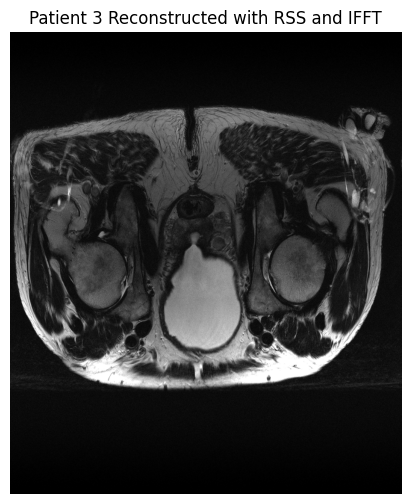

type of image_3d <class 'numpy.ndarray'>
pat3 reconstructed image shape: (30, 768, 651)
pat3 reconstructed image dtype: float32


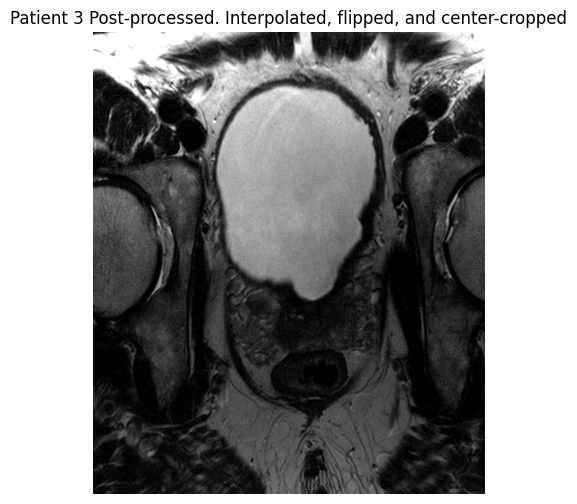

In [9]:
# Reconstruct with RSS and IFFT
pat3_recon_full = reconstruct_image_RSS(pat3["combined_kspace"])
visualize_slice(image_3d=pat3_recon_full, do_adaptive_clip=True, title = "Patient 3 Reconstructed with RSS and IFFT")

# Post-process with interpolation, flip, and center-crop
pat3_recon_post = post_process_3d_image(pat3_recon_full)
visualize_slice(image_3d=pat3_recon_post, do_adaptive_clip=True, perc_clip=(2.0, 98.0), title = "Patient 3 Post-processed. Interpolated, flipped, and center-cropped")


# See the histogram to get an idea what the contrast will be

Pixel value range: 8.792272687685454e-09 - 1.191329033645161e-06


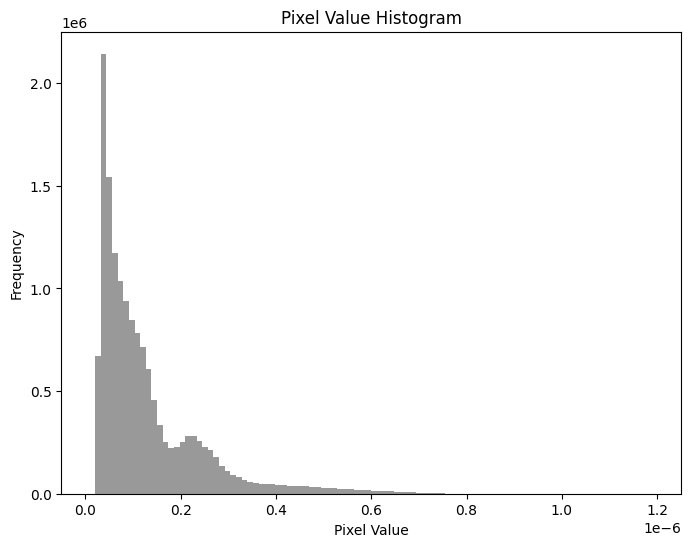

Real part range: -0.009542325511574745 to 0.007390674669295549
Imag part range: -0.007698830217123032 to 0.008320287801325321
Abs range:       0.0 to 0.010439112782478333


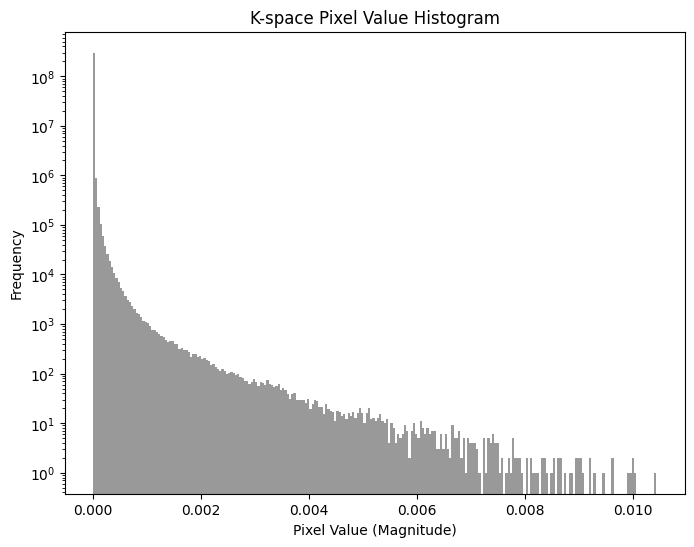

In [10]:
def make_histogram_of_image(img_3d: np.ndarray) -> None:
    """
    Create a histogram of the pixel values in the 3D image volume.

    Args:
        img_3d (np.ndarray): 3D image volume (slices, rows, columns).
    """
    assert isinstance(img_3d, np.ndarray), "img_3d must be a numpy array"
    assert img_3d.ndim == 3, f"Expected 3D (slices, rows, columns), got {img_3d.ndim}D"

    flat_img = img_3d.flatten()
    print(f"Pixel value range: {flat_img.min()} - {flat_img.max()}")

    plt.figure(figsize=(8, 6))
    plt.hist(flat_img, bins=100, color='gray', alpha=0.8)
    plt.title("Pixel Value Histogram")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.show()


def make_histogram_of_multicoil_kspace(
    k_space_4d: np.ndarray, 
    bins_mode: str = "auto", 
    log_scale: bool = False
) -> None:
    """
    Create a histogram of the pixel values in a 4D multi-coil k-space volume.
    Provides two options to address issues with very small or skewed data ranges:
      1) Control the binning strategy (e.g., fewer bins).
      2) Plot frequency on a log scale.

    Args:
        k_space_4d (np.ndarray): 4D array (slices, coils, rows, columns), dtype=complex64.
        bins_mode (str): 
            - "auto": Let matplotlib choose an automatic bin size.
            - "fewer": Use fewer bins (e.g. 500).
            - "many": Use more bins (e.g. 10_000).
        log_scale (bool): 
            - If True, the y-axis is displayed on a log scale.
    """
    assert isinstance(k_space_4d, np.ndarray), "k_space_4d must be a numpy array"
    assert k_space_4d.ndim in [3,4], f"Expected 3D or 4D (slices, [coils], rows, columns), got {k_space_4d.ndim}D"
    assert np.iscomplexobj(k_space_4d), "k_space_4d must be complex-valued"

    # Flatten the k-space data
    flat_k_space = k_space_4d.flatten()

    # Print real/imag ranges and absolute value range
    print(f"Real part range: {np.real(flat_k_space).min()} to {np.real(flat_k_space).max()}")
    print(f"Imag part range: {np.imag(flat_k_space).min()} to {np.imag(flat_k_space).max()}")
    print(f"Abs range:       {np.abs(flat_k_space).min()} to {np.abs(flat_k_space).max()}")

    # Decide on binning strategy
    if bins_mode == "auto":
        bins = "auto"  # Let matplotlib decide
    elif bins_mode == "fewer":
        bins = 250
    elif bins_mode == "many":
        bins = 10_000
    else:
        raise ValueError(f"Unknown bins_mode: {bins_mode}")

    # Prepare figure
    plt.figure(figsize=(8, 6))

    # Plot the histogram of absolute values
    plt.hist(np.abs(flat_k_space), bins=bins, color='gray', alpha=0.8)

    # Apply log scale on the y-axis if requested
    if log_scale:
        plt.yscale('log')

    plt.title("K-space Pixel Value Histogram")
    plt.xlabel("Pixel Value (Magnitude)")
    plt.ylabel("Frequency")
    plt.show()


# Create a histogram of the pixel values in the post-processed image
make_histogram_of_image(pat3_recon_post)
# make_histogram_of_multicoil_kspace(pat3["combined_kspace"][:, 0, :, :], bins_mode="auto", log_scale=False)
# make_histogram_of_multicoil_kspace(pat3["combined_kspace"][:, 0, :, :], bins_mode="fewer", log_scale=False)

# This
make_histogram_of_multicoil_kspace(pat3["combined_kspace"], bins_mode="fewer", log_scale=True)



# PART 1: Uncertainty Quantificantion (map) with Gaussian Noise in k-space Functions

In [11]:
def add_gaussian_noise(kspace: np.ndarray, sigma: float) -> np.ndarray:
    """
    Adds zero-mean complex Gaussian noise to collapsed k-space.

    Args:
        kspace (np.ndarray): Collapsed k-space, shape (slices, coils, rows, columns).
        sigma (float): Noise std dev for the real and imaginary parts.

    Returns:
        np.ndarray: k-space with added noise (same shape).
    """
    assert isinstance(kspace, np.ndarray), "kspace must be a numpy array"
    assert kspace.ndim == 4, f"Expected kspace to have 4 dimensions, got {kspace.ndim}"
    assert isinstance(sigma, (float, np.floating)), "sigma must be a float"

    # set the seeding for reproducibility
    # np.random.seed(seed)

    # noise_real = np.random.randn(*kspace.shape)
    # noise_imag = np.random.randn(*kspace.shape)
    # noise = noise_real + 1j * noise_imag
    
    # return kspace + sigma * noise

    return kspace + sigma * (np.random.randn(*kspace.shape) + 1j * np.random.randn(*kspace.shape))


def simulate_uncertainty_reconstructions(combined_kspace: np.ndarray, sigma: float, num_samples: int) -> np.ndarray:
    """
    Generate multiple reconstructions from noisy k-space for uncertainty estimation.

    Args:
        combined_kspace (np.ndarray): Collapsed k-space, shape (slices, coils, rows, columns).
        sigma (float): Noise standard deviation.
        num_samples (int): Number of noisy reconstructions.

    Returns:
        np.ndarray: Stack of reconstructed images with shape (num_samples, slices, rows, columns).
    """
    assert isinstance(combined_kspace, np.ndarray), "combined_kspace must be a numpy array"
    assert combined_kspace.ndim == 4, "combined_kspace must have 4 dimensions (slices, coils, rows, columns) The average dimension is already collapsed"
    assert isinstance(sigma, (float, np.floating)), "sigma must be a float"
    assert isinstance(num_samples, int) and num_samples > 0, "num_samples must be a positive integer"
    
    slices, coils, rows, columns = combined_kspace.shape
    reconstructions = np.empty((num_samples, slices, rows, columns), dtype=np.float32)
    
    for i in range(num_samples):
        recon = reconstruct_image_RSS(add_gaussian_noise(combined_kspace, sigma))
        reconstructions[i] = recon
    
    return reconstructions


def compute_uncertainty_map(recons: np.ndarray) -> np.ndarray:
    """
    Compute the voxel-wise standard deviation across multiple reconstructions.

    Args:
        recons (np.ndarray): Reconstructed images with shape (num_samples, slices, rows, columns).

    Returns:
        np.ndarray: Uncertainty map with shape (slices, rows, columns).
    """
    assert isinstance(recons, np.ndarray), "recons must be a numpy array"
    assert recons.ndim == 4, f"Expected recons to have 4 dimensions, got {recons.ndim}"
    return np.std(recons, axis=0)


def compute_noise_sigma(kspace: np.ndarray, fraction: float = 0.01, debug = False) -> float:
    """
    Compute noise sigma as a fraction of the maximum absolute value of the k-space data.
    
    Args:
        kspace (np.ndarray): Collapsed k-space data, shape (slices, coils, rows, columns).
        fraction (float): Fraction of the maximum amplitude to use as noise sigma.
        
    Returns:
        float: Computed noise sigma.
    """
    assert isinstance(kspace, np.ndarray), "kspace must be a numpy array"
    assert kspace.ndim == 4, "kspace must have 4 dimensions (slices, coils, rows, columns)"
    assert isinstance(fraction, float) and 0 < fraction < 1, "fraction must be a float between 0 and 1"
    max_val = np.max(np.abs(kspace))

    sigma = fraction * max_val
    if debug:
        print(f"Computed noise sigma: {sigma}, with type: {type(sigma)} with fraction {fraction} and max_val {max_val}")

    return sigma


## Part 1: Test the Uncertainty Quantification with Gaussian Noise

In [ ]:
assert pat3["combined_kspace"].ndim == 4, "pat3['combined_kspace'] must have 4 dimensions (slices, coils, rows, columns)"

# Why compute the noise sigma from the k-space data?
# The noise level can be estimated from the k-space data itself, as the noise is additive and complex-valued.
computed_sigma = compute_noise_sigma(kspace=pat3["combined_kspace"], fraction=0.0005, debug=True)

# COMPUTE THE NOISE LEVEL SIGMA BASED ON A BACKGROUND REGION INSTEAD OF THE MAX
if False:
    raise NotImplementedError("Implement the function compute_noise_sigma_from_background()")

# Single noisy reconstruction: add noise, reconstruct, and assign to pat3
# noise_sigma = 0.01  # example noise level
pat3["noisy_recon"] = reconstruct_image_RSS(add_gaussian_noise(pat3["combined_kspace"], computed_sigma))

# Generate multiple reconstructions for uncertainty estimation
num_samples = 3
pat3["noisy_recons"] = simulate_uncertainty_reconstructions(pat3["combined_kspace"], computed_sigma, num_samples)

# Compute the uncertainty map (voxel-wise standard deviation) and assign to pat3
pat3["uncertainty_map"] = compute_uncertainty_map(pat3["noisy_recons"])

# Visualize the middle slice of both the noisy reconstruction and the uncertainty map
visualize_slice(pat3["noisy_recon"], title="Noisy Reconstruction - Middle Slice")
visualize_slice(pat3["uncertainty_map"], title="Uncertainty Map (std) - Middle Slice")

Computed noise sigma: 5.2195564421708696e-06, with type: <class 'numpy.float32'> with fraction 0.0005 and max_val 0.010439112782478333


In [ ]:
write_volume_to_nii(pat3["uncertainty_map"], "pat3_uncertainty_map.nii.gz", tmpdir)

Volume written to: /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/pat3_uncertainty_map.nii.gz


# Check the k-space for zero-padding

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/0003_umcg_pst_kspskspace.png
Saved kspace image to /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/0003_umcg_pst_kspskspace.png


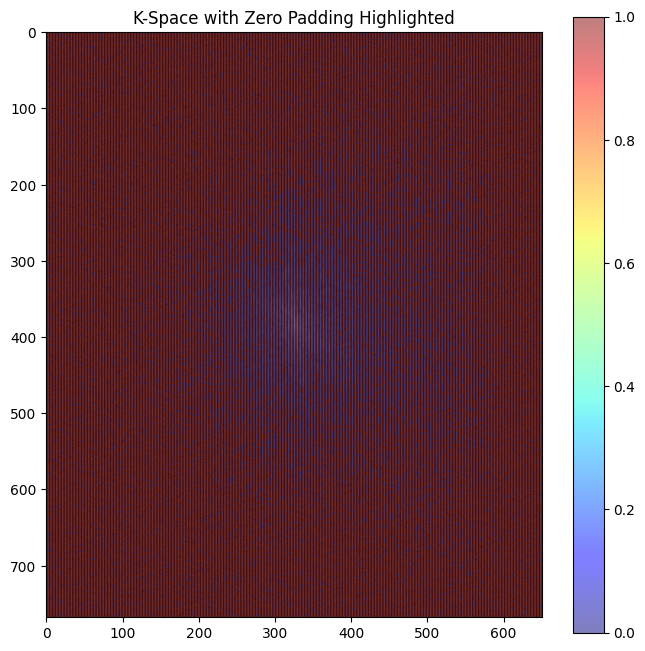

/home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/0004_ANON9616598kspace.png
Saved kspace image to /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/0004_ANON9616598kspace.png


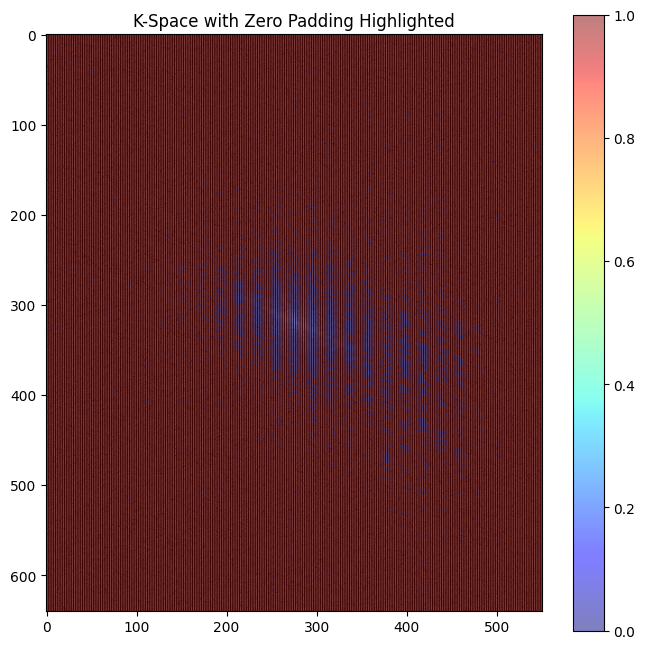

In [ ]:
def check_zero_padding(kspace: np.ndarray, threshold: float = 1e-5) -> np.ndarray:
    """
    This function checks for zero-padding in the k-space data.
    It returns a boolean array indicating where zero-padding is present (near-zero values).
    
    Args:
    kspace (np.ndarray): The k-space data array.
    threshold (float): The threshold below which values are considered zero-padding.

    Returns:
    np.ndarray: A boolean array where True indicates zero-padding, False otherwise.
    """
    assert len(kspace.shape) == 2, "Input k-space should be a 2D array (slice)"

    # Identify where the k-space values are below the threshold (indicating zero-padding)
    zero_padding_mask = np.abs(kspace) < threshold
    return zero_padding_mask


def plot_zero_padding(patient_dict: dict, threshold: float = 1e-5, epsilon: float = 1e-8):
    """
    This function visualizes the k-space slice and highlights zero-padded regions.
    
    Args:
    patient_dict (dict): The dictionary containing the patient
    threshold (float): The threshold below which values are considered zero-padding.
    epsilon (float): A small value added to avoid log(0) issues.
    """

    ksp_slice = patient_dict["slice_ksp"]

    assert len(ksp_slice.shape) == 2, "Input k-space should be a 2D array (slice)"

    # Identify zero padding and highlight it
    zero_padding_mask = check_zero_padding(ksp_slice, threshold)
    
    # Avoid log(0) by adding epsilon
    ksp_log = np.log(np.abs(ksp_slice) + epsilon)

    # Plot the k-space with a mask overlay to show zero-padded areas
    plt.figure(figsize=(8, 8))
    plt.imshow(ksp_log, cmap='gray')
    plt.imshow(zero_padding_mask, cmap='jet', alpha=0.5)  # Overlay zero-padding mask
    plt.colorbar()
    plt.title('K-Space with Zero Padding Highlighted')

    # Save the grayscale image with log(k-space) values
    fname = tmpdir / f"{patient_dict['pat_id']}kspace.png"
    print(fname)
    plt.imsave(str(fname), ksp_log, cmap='gray')
    print(f"Saved kspace image to {fname}")
    
    plt.show()


plot_zero_padding(pat3)
plot_zero_padding(pat4)

# Part 2: Uncertainty Quantification by leaving-x-out (LXO) echo trains 

## TEST: Count the number of columns that contain at least one non-zero value

In [12]:
def count_nonzero_columns(kspace_slice: np.ndarray, debug=False) -> int:
    """
    Counts the number of columns that contain at least one non-zero value.

    Args:
    - kspace_slice (np.ndarray): A 1D (rows) or 2D (rows, cols) k-space slice.

    Returns:
    - int: Number of columns that contain at least one non-zero value.
    """
    assert isinstance(kspace_slice, np.ndarray), "Input must be a NumPy array."
    assert kspace_slice.ndim in [1, 2], f"Expected 1D or 2D array, got shape {kspace_slice.shape}"

    # If input is 1D, return 1 if any value is non-zero, otherwise return 0
    if kspace_slice.ndim == 1:
        return int(np.any(kspace_slice != 0))

    # Count columns that have at least one non-zero value
    nonzero_count = np.count_nonzero(np.any(kspace_slice != 0, axis=0))

    if debug:
        print(f"Count of Non-zero columns: {nonzero_count}")

    return nonzero_count


measured_lines_n = count_nonzero_columns(pat4["slice_ksp"])
print(f"The number of actually measured lines in the k-space slice is: {measured_lines_n}")


The number of actually measured lines in the k-space slice is: 275


## STEP 1 - Identify the indices of the actually measured k-space lines (columns).

In [13]:
def get_measured_line_indices(kspace_slice: np.ndarray, debug=False) -> np.ndarray:
    """
    Identify the indices of the actually measured k-space lines (columns).
    
    Args:
    - kspace_slice (np.ndarray): A 2D k-space slice (rows, cols).

    Returns:
    - np.ndarray: Indices of the measured (non-zero) k-space lines.
    """
    assert kspace_slice.ndim == 2, "Input must be a 2D k-space slice (rows, cols)."

    # Find columns that contain at least one nonzero value
    measured_indices = np.where(np.any(kspace_slice != 0, axis=0))[0]

    if debug: 
        print(f"STEP 1 - Measured line indices: {measured_indices}")
        print(f"STEP 1 - Number of measured lines: {len(measured_indices)}")
        print(f"STEP 1 - Measured lines shape: {measured_indices.shape}")

    return measured_indices

# Test this function
measured_indices = get_measured_line_indices(pat4["slice_ksp"])
print(f"Measured line indices shape: {measured_indices.shape}")
print(f"Measured line indices: {measured_indices}")
print(len(measured_indices))


Measured line indices shape: (275,)
Measured line indices: [  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213 215
 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249 251
 253 255 257 259 261 263 265 267 269 271 273 275 277 279 281 283 285 287
 289 291 293 295 297 299 301 303 305 307 309 311 313 315 317 319 321 323
 325 327 329 331 333 335 337 339 341 343 345 347 349 351 353 355 357 359
 361 363 365 367 369 371 373 375 377 379 381 383 385 387 389 391 393 395
 397 399 401 403 405 407 409 411 413 415 417 419 421 423 425 427 429 431
 433 435 437 439 441 443 445 447 449 451 453 455 457 459 461 463 

## STEP 2 - Splits measured k-space indices into echo trains.


In [14]:
def split_into_echo_trains(measured_indices: np.ndarray, echo_train_length: int = 25, seed: int = 42, debug=False) -> List[np.ndarray]:
    """
    Splits measured k-space indices into echo trains.

    Args:
    - measured_indices (np.ndarray): The indices of actually measured lines.
    - echo_train_length (int): The number of lines per echo train.
    - seed (int): Random seed for reproducibility.

    Returns:
    - list: A list of echo train sets, each containing echo_train_length indices.
    """
    assert len(measured_indices) % echo_train_length == 0, "Measured lines must be divisible by echo train length."

    random.seed(seed)
    np.random.seed(seed)

    # Shuffle measured indices to randomize echo trains
    shuffled_indices = np.random.permutation(measured_indices)

    # Split into echo trains
    num_echo_trains = len(measured_indices) // echo_train_length
    echo_trains = np.array_split(shuffled_indices, num_echo_trains)

    if debug:
        print(f"STEP 2 - Shuffled Indices: {shuffled_indices}")
        print(f"STEP 2 - Number of echo trains: {num_echo_trains}")
        print(f"STEP 2 - Echo trains shape: {[et.shape for et in echo_trains]}")

    return echo_trains


# Test the function
measured_indices = get_measured_line_indices(pat4["slice_ksp"])
print(f"Measured line indices shape: {measured_indices.shape}")
print(f"Measured line indices: {measured_indices}")
print(len(measured_indices))
echo_trains = split_into_echo_trains(measured_indices, echo_train_length=25)
print(f"Number of echo trains: {len(echo_trains)}")
print(f"Echo train lengths: {[len(et) for et in echo_trains]}")
print(f"Echo trains: {echo_trains}")
print(f"dtype echo_trains variable: {type(echo_trains)}")
print(f"dtype echo_trains[0] variable: {type(echo_trains[0])}")


Measured line indices shape: (275,)
Measured line indices: [  1   3   5   7   9  11  13  15  17  19  21  23  25  27  29  31  33  35
  37  39  41  43  45  47  49  51  53  55  57  59  61  63  65  67  69  71
  73  75  77  79  81  83  85  87  89  91  93  95  97  99 101 103 105 107
 109 111 113 115 117 119 121 123 125 127 129 131 133 135 137 139 141 143
 145 147 149 151 153 155 157 159 161 163 165 167 169 171 173 175 177 179
 181 183 185 187 189 191 193 195 197 199 201 203 205 207 209 211 213 215
 217 219 221 223 225 227 229 231 233 235 237 239 241 243 245 247 249 251
 253 255 257 259 261 263 265 267 269 271 273 275 277 279 281 283 285 287
 289 291 293 295 297 299 301 303 305 307 309 311 313 315 317 319 321 323
 325 327 329 331 333 335 337 339 341 343 345 347 349 351 353 355 357 359
 361 363 365 367 369 371 373 375 377 379 381 383 385 387 389 391 393 395
 397 399 401 403 405 407 409 411 413 415 417 419 421 423 425 427 429 431
 433 435 437 439 441 443 445 447 449 451 453 455 457 459 461 463 

## STEP 3 - Generates leave-X-out sets by selecting which echo trains to remove per reconstruction.

In [15]:
def generate_leave_x_out_sets(echo_trains: list, num_reconstructions: int = 5, leave_x_out: int = 2, seed: int = 42, debug=False) -> list:
    """
    Generates leave-X-out sets by selecting which echo trains to remove per reconstruction.

    Args:
    - echo_trains (list): List of echo train arrays.
    - num_reconstructions (int): Number of reconstructions (default = 5).
    - leave_x_out (int): Number of echo trains to leave out in each reconstruction.
    - seed (int): Random seed for reproducibility.

    Returns:
    - list: List of reconstruction sets, where each contains indices of kept lines.
    """
    num_echo_trains = len(echo_trains)

    assert num_reconstructions > 0, "Number of reconstructions must be positive."
    assert leave_x_out < num_echo_trains, "Cannot leave out more echo trains than available."

    # Set seed for reproducibility
    random.seed(seed)

    reconstruction_sets = []
    for _ in range(num_reconstructions):
        # Randomly choose echo trains to remove
        removed_trains = random.sample(range(num_echo_trains), leave_x_out)

        # Keep only the indices that are not in the removed echo trains
        kept_lines = np.concatenate([echo_trains[i] for i in range(num_echo_trains) if i not in removed_trains])

        reconstruction_sets.append(kept_lines)

    if debug:
        print(f"STEP 3 - Removed echo trains: {removed_trains}")
        print(f"STEP 3 - dtype removed_trains variable: {type(removed_trains)}")
        print(f"STEP 3 - Kept lines: {kept_lines}")
        print(f"STEP 3 - dtype kept_lines variable: {type(kept_lines)}")
        print(f"STEP 3 - Reconstruction sets: {reconstruction_sets}")
        print(f"STEP 3 - dtype reconstruction_sets variable: {type(reconstruction_sets)}")

    return reconstruction_sets


# Test the function
# 1. Get measured line indices, output is a 1D array
measured_indices = get_measured_line_indices(pat4["slice_ksp"])
print(f"Measured line indices shape: {measured_indices.shape}")

# 2. Split into echo trains, output is a list of arrays
echo_trains = split_into_echo_trains(measured_indices, echo_train_length=25)
print(f"Number of echo trains: {len(echo_trains)}")
print(f"Echo train lengths: {[len(et) for et in echo_trains]}")
print(f"dtype echo_trains variable: {type(echo_trains)}")
print(f"dtype echo_trains[0] variable: {type(echo_trains[0])}")

# 3. Generate leave-X-out sets, output is a list of arrays
reconstruction_sets = generate_leave_x_out_sets(echo_trains, num_reconstructions=5, leave_x_out=2, debug=True)

print(f"the length of the first reconstruciton set = {len(reconstruction_sets[0])}")

Measured line indices shape: (275,)
Number of echo trains: 11
Echo train lengths: [25, 25, 25, 25, 25, 25, 25, 25, 25, 25, 25]
dtype echo_trains variable: <class 'list'>
dtype echo_trains[0] variable: <class 'numpy.ndarray'>
STEP 3 - Removed echo trains: [10, 8]
STEP 3 - dtype removed_trains variable: <class 'list'>
STEP 3 - Kept lines: [ 61 279 391 253 431 467 501 405 507 285 159 395 455 529 527 293 401 121
 169 477  91 147 359 421 365 419 331  85  19 231  45 217  49 239 255 151
 461 465  13 137  93 251 133  51 227 265  39 519 425 209 173 371 317  31
 315  21 521 535  67 445 295 187  75 433  33 341 479 135 523 203 181 389
 513 155  37 237 403 185 165 225 111 305 413  77 319 223 115 195 287 351
  63 503 157 373 235 511 309 407 353 545 517 139 547   5 153 219 289 297
 193 229 399 357 441 149 249  59 443 435 481 241 533  11 233 113 311 361
 281 131 335 171 355  25  71  57 495 275 103 191 345 369  83 449 363 273
  53 537 283 329   1 475 201 427 417 197  73 123 301 387 463  23 543 469
  55

## STEP 4 - Simulate uncertainty quantification by performing Leave-X-Out reconstruction.

In [ ]:
def leave_x_out_reconstructions(
        kspace_1_avg: np.ndarray, 
        leave_x_out: int = 2, 
        echo_train_length: int = 25,
        slice_idx: int = 0,
        num_reconstructions: int = 5,
        seed: int = 42,
        debug = False
    ) -> tuple[np.ndarray, np.ndarray]:
    """
    Simulate uncertainty quantification by performing Leave-X-Out reconstruction on 
    multi-coil k-space data from a single average.

    Args:
        kspace_1_avg (np.ndarray): K-space data of shape (slices, coils, rows, cols).
        leave_x_out (int): Number of echo trains to leave out per reconstruction.
        echo_train_length (int): Number of lines in each echo train.
        slice_idx (int): The slice index to process.
        num_reconstructions (int): Number of reconstructions.
        coil_combination_fn (callable): Function to combine coils (e.g., combine_coils_RSS). 
                                        If None, a default multi-coil reconstruction is used.
        seed (int): Random seed for reproducibility.

    Returns:
        reconstructions (np.ndarray): Array of shape (num_reconstructions, rows, cols) with reconstructions.
        uncertainty_map (np.ndarray): Standard deviation map computed across reconstructions.
    """
    assert isinstance(kspace_1_avg, np.ndarray), "kspace_1_avg must be a NumPy array."
    assert kspace_1_avg.ndim == 4, f"Expected k-space shape (slices, coils, rows, cols), got {kspace_1_avg.shape}"
    assert 0 <= slice_idx < kspace_1_avg.shape[0], f"slice_idx out of range (0 to {kspace_1_avg.shape[0]-1})"
    assert leave_x_out > 0, "leave_x_out must be a positive integer."
    assert echo_train_length > 0, "echo_train_length must be a positive integer."
    assert num_reconstructions > 0, "num_reconstructions must be a positive integer."
    print("kspace_1_avg shape:", kspace_1_avg.shape) if debug else None

    num_slices, num_coils, rows, cols = kspace_1_avg.shape
    # kspace_slice = kspace_1_avg[slice_idx]

    # Step 1: Get measured line indices of 1 slice. This is the same for each slice and each coil
    measured_indices = get_measured_line_indices(kspace_1_avg[0, 0, ...], debug = debug)

    # Step 2: Split measured indices into echo trains
    echo_trains = split_into_echo_trains(measured_indices, echo_train_length, seed, debug = debug)

    # Step 3: Generate leave-X-out sets (each is a list/array of column indices to keep)
    reconstruction_sets = generate_leave_x_out_sets(echo_trains, num_reconstructions, leave_x_out, seed, debug = debug)
    print(f"num reconstructions: {num_reconstructions}") if debug else None
    print(f"len reconstruction sets: {len(reconstruction_sets)}") if debug else None
    
    # Preallocate output array for efficiency
    reconstructions = np.empty((num_reconstructions, num_slices, rows, cols), dtype=np.float32)
    
    # Preallocate a buffer for modified k-space for one volume: shape (slices, coils, rows, cols)
    kspace_modified = np.empty_like(kspace_1_avg)

    # Step 4: For each leave-X-out set, modify k-space and reconstruct using multi-coil data
    for i, kept_lines in enumerate(reconstruction_sets):
        print(f"Reconstruction {i+1}/{num_reconstructions}")
        kspace_modified.fill(0)   # Reset the entire modified k-space volume
        # For every slice and every coil, only copy the columns that are kept.
        kspace_modified[:, :, :, kept_lines] = kspace_1_avg[:, :, :, kept_lines]
        reconstructions[i] = reconstruct_image_RSS(kspace_modified)  # Expects multi-coil 4D complex data

    return reconstructions

#### Normlization for visualization

In [17]:
def norm_rescale01(recons: np.ndarray) -> np.ndarray:
    """
    Normalize each reconstruction in a 4D array individually to the range [0, 1].
    
    Args:
        recons (np.ndarray): Array of shape (num_reconstructions, slices, rows, cols).
    
    Returns:
        np.ndarray: Normalized 4D array with each reconstruction scaled to [0, 1].
    """
    assert isinstance(recons, np.ndarray), "recons must be a NumPy array."
    assert recons.ndim == 4, f"Expected 4D array, got shape {recons.shape} of shape: (num_reconstructions, slices, rows, cols)"

    normalized = np.empty_like(recons)
    for i in range(recons.shape[0]):
        rec = recons[i]
        rec_min = rec.min()
        rec_max = rec.max()
        # Add a small epsilon to avoid division by zero.
        normalized[i] = (rec - rec_min) / (rec_max - rec_min + 1e-8)
    return normalized

### Test the UQ code with Patient 4

In [41]:
num_reconstructions = 30
slice_idx = 15
LXO = 8

# Run Leave-2-Out (L2O) Uncertainty Estimation on Slice 10
# IMPORTANT kspace_r3 = pat4["kspace"][0]  # Shape: (0, 30, 20, 768, 651)

# STEP 1 - Compute the LXO Reconstructions
reconstructions = leave_x_out_reconstructions(
    kspace_1_avg        = pat4["combined_kspace"],
    leave_x_out         = LXO,
    echo_train_length   = 25,
    slice_idx           = slice_idx,
    num_reconstructions = num_reconstructions,
    seed                = 42,
    debug               = False
)

print(f"Shape of reconstructions: {reconstructions.shape}")

Reconstruction 1/30
Reconstruction 2/30
Reconstruction 3/30
Reconstruction 4/30
Reconstruction 5/30
Reconstruction 6/30
Reconstruction 7/30
Reconstruction 8/30
Reconstruction 9/30
Reconstruction 10/30
Reconstruction 11/30
Reconstruction 12/30
Reconstruction 13/30
Reconstruction 14/30
Reconstruction 15/30
Reconstruction 16/30
Reconstruction 17/30
Reconstruction 18/30
Reconstruction 19/30
Reconstruction 20/30
Reconstruction 21/30
Reconstruction 22/30
Reconstruction 23/30
Reconstruction 24/30
Reconstruction 25/30
Reconstruction 26/30
Reconstruction 27/30
Reconstruction 28/30
Reconstruction 29/30
Reconstruction 30/30
Shape of reconstructions: (30, 31, 640, 551)


min of reconstruction of pat4: 0.0, max of reconstruction of pat4: 0.9908502101898193
min of uncertainty map of pat4: 0.0004321956657804549, max of uncertainty map of pat4: 0.14037176966667175


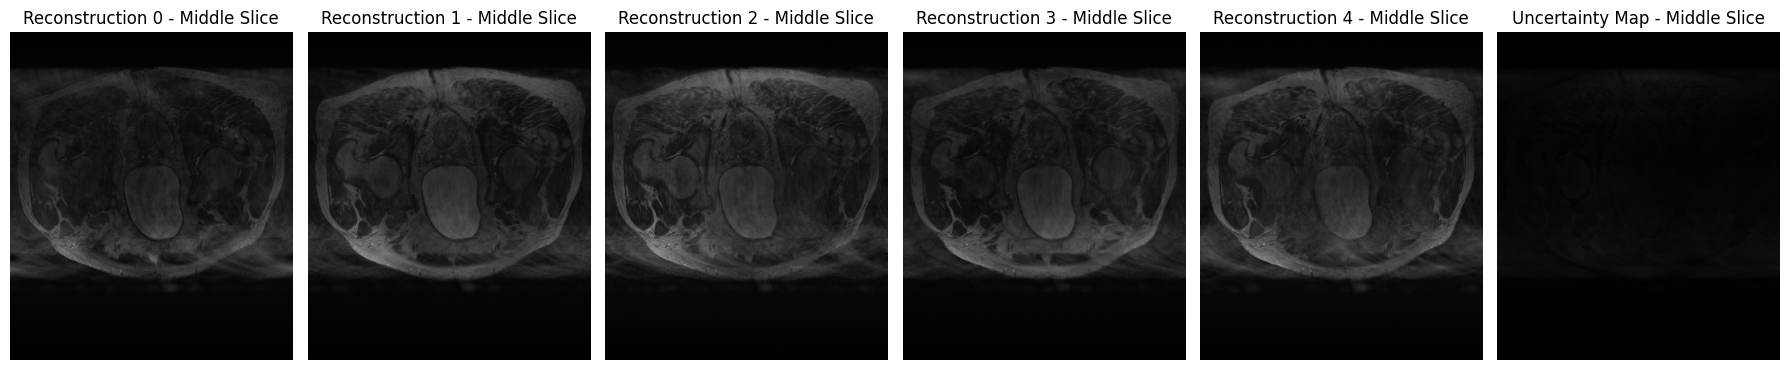

Volume written to: /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/pat4_reconstruction_L8O_comb.nii.gz
Volume written to: /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/pat4_uncertainty_map_L8O_comb.nii.gz


In [46]:
# STEP 2 - Normalize and rescale the reconstructions
pat4[f"reconstructions_L{LXO}O_comb"] = norm_rescale01(reconstructions)
recon_min, recon_max = np.min(pat4[f"reconstructions_L{LXO}O_comb"]), np.max(pat4[f"reconstructions_L{LXO}O_comb"])
print(f"min of reconstruction of pat4: {recon_min}, max of reconstruction of pat4: {recon_max}")

# STEP 3 - Compute the Uncertainty Map
pat4[f"uncertainty_map_L{LXO}O_comb"] = np.std(pat4[f"reconstructions_L{LXO}O_comb"], axis=0)
uq_min, uq_max = np.min(pat4[f"uncertainty_map_L{LXO}O_comb"]), np.max(pat4[f"uncertainty_map_L{LXO}O_comb"])
print(f"min of uncertainty map of pat4: {uq_min}, max of uncertainty map of pat4: {uq_max}")

# VISUALIZATION
# View the same slice of all 5 reconstructions of pat4["reconstructions_L2O_comb"]
fig, axes = plt.subplots(1, 6, figsize=(18, 6))  # Create a row of 6 subplots

for i in range(5):
    ax = axes[i]
    ax.imshow(pat4[f"reconstructions_L{LXO}O_comb"][i][15], cmap='gray', vmin=0, vmax=1)
    ax.set_title(f"Reconstruction {i} - Middle Slice")
    ax.axis('off')

# Add the uncertainty map as the 6th figure
ax = axes[5]
ax.imshow(pat4[f"uncertainty_map_L{LXO}O_comb"][15], cmap='gray', vmin=0, vmax=1)
ax.set_title("Uncertainty Map - Middle Slice")
ax.axis('off')
plt.tight_layout()
plt.savefig(tmpdir / f"pat4_reconstructions_L{LXO}O_comb_uncertainty_map.png")
plt.show()

write_volume_to_nii(pat4[f"reconstructions_L{LXO}O_comb"][0], f"pat4_reconstruction_L{LXO}O_comb.nii.gz", tmpdir)
write_volume_to_nii(pat4[f"uncertainty_map_L{LXO}O_comb"], f"pat4_uncertainty_map_L{LXO}O_comb.nii.gz", tmpdir)

### TEST the UQ code but the for combined k-spac so that we dont get these ringing artifacts and see what the map looks like then.
We must ensure that we leave out more echo trains then. Because instead of having half the lines that are actually measured we have all of them, so LXO should be 2x think. Lets see:

kspace_1_avg shape: (31, 26, 640, 551)
STEP 1 - Measured line indices: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 

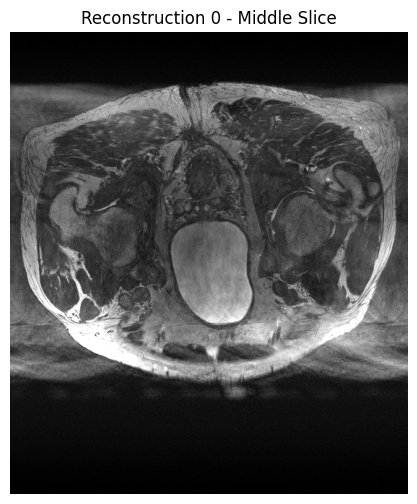

type of image_3d <class 'numpy.ndarray'>
pat3 reconstructed image shape: (31, 640, 551)
pat3 reconstructed image dtype: float32


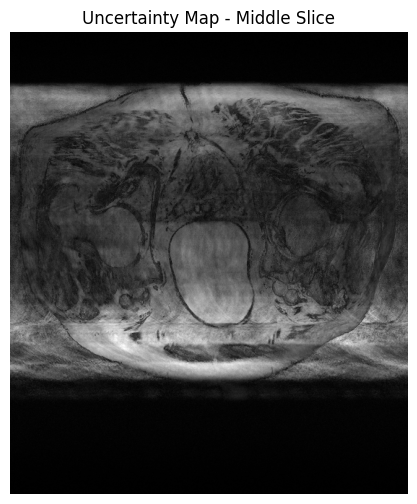

In [ ]:
# WORK ON AVERAGED KSPACE DATA, SO AVG1, AVG2, AVG3 ARE COMBINED.
reconstructions, uncertainty_map = leave_x_out_reconstructions(
    kspace_1_avg        = pat4["combined_kspace"],
    leave_x_out         = 1,
    echo_train_length   = pat4['echo_train_length'],
    slice_idx           = 15,
    num_reconstructions = 9,
    seed                = 42,
    debug               = True
)

pat4["reconstructions_L1O"] = reconstructions
pat4["uncertainty_map_L1O"] = uncertainty_map

visualize_slice(pat4["reconstructions_L1O"][0], do_adaptive_clip=True, title="Reconstruction 0 - Middle Slice")
visualize_slice(pat4["uncertainty_map_L1O"], do_adaptive_clip=False, title="Uncertainty Map - Middle Slice")

# lets write these to nifti for now

In [ ]:
for k, v in pat4.items():
    print(k)

write_volume_to_nii(pat4["uncertainty_map_L2O"], "pat4_uncertainty_map_L2O.nii.gz", tmpdir)
write_volume_to_nii(pat4["uncertainty_map_L3O"], "pat4_uncertainty_map_L3O.nii.gz", tmpdir)
write_volume_to_nii(pat4["uncertainty_map_L4O"], "pat4_uncertainty_map_L4O.nii.gz", tmpdir)

h5_path
pat_id
kspace
slice_idx
avg_idx
coil_idx
slice_ksp
slice_img
combined_kspace
leave_x_out
echo_train_length
num_reconstructions
reconstructions_L2O
uncertainty_map_L2O
reconstructions_L4O
uncertainty_map_L4O
reconstructions_L2Ov2
uncertainty_map_L2Ov2
reconstructions_L3O
uncertainty_map_L3O
Volume written to: /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/pat4_uncertainty_map_L2O.nii.gz
Volume written to: /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/pat4_uncertainty_map_L3O.nii.gz
Volume written to: /home1/p290820/repos/Uncertainty-Quantification-Prostate-MRI/tmp/pat4_uncertainty_map_L4O.nii.gz
